# Inference

In [1]:
# External Libs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import pandas as pd
import os
import scipy
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from rainbowgram.wave_rain import wave2rain, rain2wave
from rainbowgram.rain2graph import rain2graph
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Internal Libs
from lib import networks, util, signal_utils
from lib.normalizer import DataNormalizer
from data.nsynth_loader import NSynth, to_one_hot, expand
from data.fsd_nsynth_loader import NsynthFSD

Loading Configuration JSON file

In [2]:
option_name = 'dualaeclassdis_dualnsynth_fsd38nsynth28_weightrecon1_class1_dis1.json'
option_path = os.path.join('./options/', option_name)

opt = util.load_json(option_path)
opt_train = opt['train']
checkpoints_path = os.path.join(opt_train['checkpoints_dir'], opt['experiment_name'])
output_dir = os.path.join(checkpoints_path, opt_train['output_dir'])
util.mkdir(output_dir)
device = 'cuda:0'
#color_labels = {1 :'brass', 2:'flute', 5 : 'mallet', 7 :'reed', 8 : 'string'} # TODO: erase, old labels
print('DEVICE: {}'.format(device))

DEVICE: cuda:0


Building a label dictionary for family source ID

In [3]:
opt['data']['sample_size'] = 1
print(opt['data']['sample_size'])

1


Loading dataset loader

In [4]:
dataset = NSynth(opt['data'])
dataset.augmentation_enabled=False
datapath = os.path.join(dataset.root,'audio')
print("Training set size: {}".format(len(dataset)))
df = dataset.df

evalset = NSynth(opt['data'], is_train=False)
evalset.augmentation_enabled=False
eval_datapath = os.path.join(evalset.root, 'audio')
print("Validation set size: {}".format(len(evalset)))
df_eval = evalset.df

all_df = pd.concat([df, df_eval], axis=0)

df.head()

KeyError: 'meta_file'

In [4]:
dataset = NsynthFSD(opt['data'], size=36676)
dataset.augmentation_enabled=False
datapath = os.path.join(dataset.root,'audio')
print("Training set size: {}".format(len(dataset)))
df = dataset.nsynth_df

evalset = NsynthFSD(opt['data'], size=5701, is_train=False)
evalset.augmentation_enabled=False
eval_datapath = os.path.join(evalset.root, 'audio')
print("Validation set size: {}".format(len(evalset)))
df_eval = evalset.nsynth_df

all_df = pd.concat([df, df_eval], axis=0)

df.head()

WARNING. Normalization parameters are hardcoded!
s_a: 0.0795
s_b: 0.299
p_a: 1
p_b: 0
Training set size: 50
WARNING. Normalization parameters are hardcoded!
s_a: 0.0795
s_b: 0.299
p_a: 1
p_b: 0
Validation set size: 50


note  sample_rate  pitch  instrument_source instrument_family_str  \
0   16629        16000     82                  0                guitar   
1   88495        16000     50                  1                 organ   
2  146382        16000     26                  1                guitar   
3  244275        16000     79                  1                 organ   
4  282051        16000     44                  1              keyboard   

            instrument_str                         note_str  \
0      guitar_acoustic_001      guitar_acoustic_001-082-050   
1     organ_electronic_120     organ_electronic_120-050-127   
2    guitar_electronic_021    guitar_electronic_021-026-025   
3     organ_electronic_011     organ_electronic_011-079-075   
4  keyboard_electronic_089  keyboard_electronic_089-044-100   

              qualities_str instrument_source_str  velocity  \
0              [percussive]              acoustic        50   
1                        []            electronic       127   
2  [fast_decay, percussive]            electronic        25   
3                  [bright]            electronic        75   
4                        []            electronic       100   

   instrument_family  instrument                       qualities  stage  \
0                  3          39  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]  train   
1                  6         979  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  train   
2                  3         346  [0, 0, 0, 1, 0, 0, 0, 1, 0, 0]  train   
3                  6         188  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  train   
4                  4         877  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  train   

   family_source_id                             file  
0                 8      guitar_acoustic_001-082-050  
1                18     organ_electronic_120-050-127  
2                 9    guitar_electronic_021-026-025  
3                18     organ_electronic_011-079-075  
4                12  keyboard_electronic_089-044-100

In [5]:
color_labels = {}

for label in sorted(df['family_source_id'].unique()):
    filtered_row = df[df['family_source_id'] == label].sample(1)
    string = '{}_{}'.format(str(filtered_row.iloc[0]['instrument_family_str']), str(filtered_row.iloc[0]['instrument_source_str']))
    color_labels.update({int(label): string})
print(color_labels)

{0: 'bass_acoustic', 1: 'bass_electronic', 2: 'bass_synthetic', 3: 'brass_acoustic', 4: 'brass_electronic', 5: 'flute_acoustic', 6: 'flute_electronic', 7: 'flute_synthetic', 8: 'guitar_acoustic', 9: 'guitar_electronic', 10: 'guitar_synthetic', 11: 'keyboard_acoustic', 12: 'keyboard_electronic', 13: 'keyboard_synthetic', 14: 'mallet_acoustic', 15: 'mallet_electronic', 16: 'mallet_synthetic', 17: 'organ_acoustic', 18: 'organ_electronic', 19: 'reed_acoustic', 20: 'reed_electronic', 21: 'reed_synthetic', 22: 'string_acoustic', 23: 'string_electronic', 24: 'synth_lead_synthetic', 25: 'vocal_acoustic', 26: 'vocal_electronic', 27: 'vocal_synthetic'}


Loading network and parameters for autoencoder

In [5]:
autoencoder =  networks.instantiate_net(opt['model']['ae_net']).to(device)

snap_path = os.path.join(checkpoints_path, 'snap')
autoencoder.load_state_dict(torch.load(os.path.join(snap_path, 'latest_AE.pth'), map_location=device))

<All keys matched successfully>

In [7]:
disc_p =   networks.Classifier(opt['model']['timbre_latent_size'], opt['data']['pitch_size']).to(device)

snap_path = os.path.join(checkpoints_path, 'snap')
disc_p.load_state_dict(torch.load(os.path.join(snap_path, 'latest_DISC_P.pth'), map_location=device))

disc_t =   networks.Classifier(opt['model']['pitch_latent_size'], opt['data']['timbre_size']).to(device)

snap_path = os.path.join(checkpoints_path, 'snap')
disc_t.load_state_dict(torch.load(os.path.join(snap_path, 'latest_DISC_T.pth'), map_location=device))

KeyError: 'timbre_latent_size'

In [18]:
autoencoder = networks.SmallGanSynthDDClass(device, 84, 1, 64, 64, 352, opt['model']['drop_prob']).to(device)
random_mask = autoencoder.class_ddln.linears[0].dropout_masks.clone()


snap_path = os.path.join(checkpoints_path, 'snap')
autoencoder.load_state_dict(torch.load(os.path.join(snap_path, 'latest_AE.pth'), map_location=device))
saved_mask = autoencoder.class_ddln.linears[0].dropout_masks.clone()
print(random_mask.eq(saved_mask))

AttributeError: module 'lib.networks' has no attribute 'SmallGanSynthDDClass'

In [9]:
#autoencoder = networks.SmallGanSynthClass(1, 64, 64, 352).to(device)
autoencoder = networks.GanSynthClass(opt['model']['in_ch'], 64, 64, 28).to(device)
# random_mask = autoencoder.class_ddln.linears[0].dropout_masks.clone()


snap_path = os.path.join(checkpoints_path, 'snap')
autoencoder.load_state_dict(torch.load(os.path.join(snap_path, 'latest_AE.pth'), map_location=device))
# saved_mask = autoencoder.class_ddln.linears[0].dropout_masks.clone()

<All keys matched successfully>

In case the autoencoder model is splited into two different instances, encoder/decoder

In [ ]:
class Autoencoder():
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def encode(self, data):
        return self.encoder(data)
    
    def decode(self, data):
        return self.decoder(data)
    
    def __call__(self, data):
        latent = self.encode(data)
        return self.decode(latent), latent
        

encoder = networks.instantiate_encoder(opt).to(device)
decoder = networks.instantiate_decoder(opt).to(device)

snap_path = os.path.join(checkpoints_path, 'snap')
encoder.load_state_dict(torch.load(os.path.join(snap_path, 'latest_encoder.pth'), map_location=device))
decoder.load_state_dict(torch.load(os.path.join(snap_path, 'latest_decoder.pth'), map_location=device))
autoencoder = Autoencoder(encoder, decoder)

In [ ]:
eval_config = {'phase': len(autoencoder.encoder.enc_net)-1, 'alpha': 0, 'status':'stable'}
autoencoder.encoder.config = eval_config
autoencoder.decoder.config = eval_config

In [ ]:
'mel' in dataset.mag_format

### Helper Functions

In [7]:
def read_sample(sample_name, datapath=datapath):
    _, sample = scipy.io.wavfile.read(os.path.join(datapath, sample_name + '.wav'))
    return sample/ np.iinfo(np.int16).max # normalize [-1,1]

def get_datapath(file_name, datapath = opt['data']['data_path']):
    sample_row = all_df[all_df['file'] == file_name].sample(1)
    return os.path.join(datapath, 
                        'nsynth-{}'.format(sample_row.iloc[0]['stage']),
                        'audio')

def read_samples_librosa(sample_name):
    sample, sr = librosa.load(os.path.join(datapath, sample_name + '.wav'), sr= dataset.rate, mono = True)
    sample = dataset.normalize_audio(sample)
    return dataset.window_sample(sample)
    
def generate(data, recon_only=False):
    if recon_only:
        decoded_feat = autoencoder(data)[0]
        decoded_feat = decoded_feat.squeeze().cpu().detach().numpy()
        return decoded_feat
    else:
        decoded_feat, latent = autoencoder(data)
        decoded_feat = decoded_feat.squeeze().cpu().detach().numpy()
        return decoded_feat, latent

def interpolate(data_1, data_2, pitch, alpha=0.5):
    latent_1, skip_1 = autoencoder.encode(data_1)
    #latent_1 = encoder(data_norm.normalize(data_1))
    latent_2, skip_2 = autoencoder.encode(data_2)
    #latent_2 = encoder(data_norm.normalize(data_2))
    
    latent = latent_1 * alpha + (1-alpha) * latent_2
    
    #decoded_feat = autoencoder.decoder(latent, to_one_hot(128, pitch).unsqueeze(0).to(device))
    decoded_feat = autoencoder.decode(latent, skip_1)
    decoded_feat = decoded_feat.squeeze().cpu().detach().numpy()
    return reconstruct(decoded_feat[0,:,:],decoded_feat[1,:,:])

def arrange_data(sample, start=0, end=1):
    sample = sample.astype(np.float)
    sample = dataset.window_sample(sample, start, end)
    if dataset.include_phase == 2:
        mag, phase = dataset.compute_features(sample)
        mag = torch.from_numpy(mag).float()
        mag = mag.unsqueeze(0)
        phase = torch.from_numpy(phase).float()
        phase = phase.unsqueeze(0)
        data = torch.cat([mag, phase], dim = 0)
    else:
        mag = dataset.compute_features(sample)
        mag = torch.from_numpy(mag).float()
        mag = mag.unsqueeze(0)
        data = mag

    data = dataset.data_norm.normalize(data)
    data = data.unsqueeze(0).to(device) # Batch dim
    return data

def denorm(spec=None, IF=None):
    if spec is not None:
        spec = dataset.data_norm.denormalize(spec)
    if IF is not None:
        IF = dataset.data_norm.denormalize_IF(IF)
    return spec, IF

def reconstruct_phase(IF):
    return np.cumsum(IF * np.pi, axis=1)

def wrap(unwrapped_p):
    return (unwrapped_p + np.pi) % (2 * np.pi) - np.pi

def unwrap(wrapped_p):
    return (wrapped_p + 2 * np.pi) % (2 * np.pi)

# def reconstruct(data, n_iter=32, verbose=False):
#     spec = data[0,:,:] if len(data.shape) == 3 else data
#     IF = data[1,:,:] if dataset.include_phase == 2 else None
#     spec, IF = denorm(spec = spec, IF = IF)
#     if 'mel' in dataset.mag_format:
#         spec, IF = signal_utils.melspecgrams_to_specgrams(spec, IF, mel_downscale=dataset.n_fft//(2*dataset.n_mel))
#     spec = np.vstack((spec,spec[-1]))
#     spec =  np.exp(spec) - 1.0e-6
#     reconstruct_magnitude = np.abs(spec)
#     if IF is not None:
#         IF = np.vstack((IF,IF[-1]))
#         reconstruct_phase_angle = reconstruct_phase(IF)
#         stft = polar2rect(reconstruct_magnitude, reconstruct_phase_angle)
#         audio = librosa.istft(stft, hop_length = 512, win_length=2048, window = 'hann')
#     else:
#         if verbose:
#             print("Reconstructic waveform via Griffin-Lim with {}".format(n_iter))
#         audio = librosa.griffinlim(reconstruct_magnitude, n_iter= n_iter, 
#                                 hop_length=dataset.hop, win_length=dataset.win_len)
#     return audio

def reconstruct(data, n_iter=32, verbose=False):
    '''Using librosa to recover signal'''
    spec = data[0,:,:] if len(data.shape) == 3 else data
    IF = data[1,:,:] if dataset.include_phase == 2 else None
    spec, IF = denorm(spec = spec, IF = IF)
    spec =  np.exp(spec) - 1.0e-6
    if 'mel' in dataset.mag_format:
        spec = np.dot(dataset.mel_filter.T, spec)
    else:
        spec = np.vstack((spec,spec[-1]))
    if IF is not None:
        IF = np.vstack((IF,IF[-1]))
        reconstruct_phase_angle = reconstruct_phase(IF)
        stft = polar2rect(reconstruct_magnitude, reconstruct_phase_angle)
        audio = librosa.istft(stft, hop_length = 512, win_length=2048, window = 'hann')
    else:
        if verbose:
            print("Reconstructic waveform via Griffin-Lim with {}".format(n_iter))
        audio = librosa.griffinlim(spec, n_iter= n_iter, 
                                hop_length=dataset.hop, win_length=dataset.win_len)
    return audio

def polar2rect(mag, phase_angle):
    """Convert polar-form complex number to its rectangular form."""
    temp_mag = np.zeros(mag.shape,dtype=np.complex_)
    temp_phase = np.zeros(mag.shape,dtype=np.complex_)

    for i, time in enumerate(mag):
        for j, time_id in enumerate(time):
            temp_mag[i,j] = np.complex(mag[i,j])

    for i, time in enumerate(phase_angle):
        for j, time_id in enumerate(time):
            temp_phase[i,j] = np.complex(np.cos(phase_angle[i,j]), np.sin(phase_angle[i,j]))
    return temp_mag * temp_phase

def export_audio(sample, path, rate= 16000):
    sample=np.int16(sample/np.max(np.abs(sample)) * 32767)
    scipy.io.wavfile.write(path, rate, sample)

def linear_norm(x, lower_bound=-1, upper_bound=1):
    min_value = np.min(x)
    max_value = np.max(x)
    return (upper_bound-lower_bound)*(x - min_value)/(max_value - min_value) - lower_bound

def plot_spectrogram_from_samples(sample):
    sample = sample.astype(np.float)
    spec = librosa.stft(sample, n_fft=dataset.n_fft, 
                    hop_length = dataset.hop, win_length=dataset.win_len)

    fig = plt.figure(figsize=(15,5))
    # Plotting Log Mag
    mag = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
    ax1 = plt.subplot(1,2,1)
    librosa.display.specshow(mag, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-frequency power spectrogram')
    
    # Plotting IF
    angle =np.angle(spec)
    IF = signal_utils.instantaneous_frequency(angle, time_axis=1)[:1024]
    ax2 = plt.subplot(1,2,2, sharex=ax1)
    librosa.display.specshow(IF, y_axis='log')
    plt.colorbar()
    plt.title('Instantaneous Freq.')

def rainbowgram(sample, rate = 16000):
    sample = sample.astype(np.float)
    rain = wave2rain(sample, sr=rate, stride=256, log_mag=True, clip=0.1)
    rain2graph(rain)
    fig, ax = plt.subplots()
    ax.show()
    
def plot_spectrogram_spec(spec, IF, is_denorm= False, is_mel=True, y_axis = 'log'):
    if not is_denorm:
        spec, IF = denorm(spec, IF)
    if is_mel:
        spec, IF = signal_utils.melspecgrams_to_specgrams(spec, IF)
    # Removing outliers for a correct visualization
    plt.figure()
    librosa.display.specshow(spec, y_axis=y_axis)
    plt.colorbar()
    plt.title('Log-frequency Power Spectrogram')

def plot_spectrogram_IF(data, is_denorm= False, is_mel=True, y_axis = 'log'):
    spec = data[0,:,:] if len(data.shape) == 3 else data
    IF = data[1,:,:] if dataset.include_phase == 2 else None
    if IF is None:
        return
    if not is_denorm:
        spec, IF = denorm(spec, IF)
    if is_mel:
        spec, IF = signal_utils.melspecgrams_to_specgrams(spec, IF, dataset.n_fft//(2*dataset.n_mel))
    # Removing outliers for a correct visualization
    IF[IF<-1.5] = -1.5
    IF[IF>1.5] = 1.5
    plt.figure()
    librosa.display.specshow(IF, y_axis=y_axis)
    plt.colorbar()
    plt.title('Log-frequency Phase Spectrogram')

def plot_spec(data, scale='log', title='Spec'):
    plt.figure()
    librosa.display.specshow(data, y_axis=scale)
    plt.colorbar()
    plt.title(title)

def scatter_fuzzy(x, y, method='pca', export=False, title='', colormap = 'winter'): #hsv for multiple colormap
    if method == 'pca':
        pca = PCA(2)
        projection = pca.fit_transform(x)
    elif method == 't-sne':
        projection = TSNE(random_state=123).fit_transform(x)        
    fig, ax = plt.subplots(1,1, figsize=(7, 7))
    plot = ax.scatter(projection[:, 0], projection[:, 1], c=y, edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap(colormap, len(np.unique(y))))
    fig.colorbar(plot, ax=ax, orientation='vertical')

def scatter_labels(x,y, method='pca', export=False, title='', color_labels= None): #colormap = 'winter'
    # Instance of the model and fitting the data.
    if method == 'pca':
        pca = PCA(2)
        projection = pca.fit_transform(x)
    elif method == 't-sne':
        projection = TSNE(random_state=123).fit_transform(x)
        
    colors = plt.cm.rainbow(np.linspace(0,1,len(np.unique(y))))
    fig, ax = plt.subplots(figsize = (7,7))
    for idx, color_id in enumerate(np.unique(y)):
        ix = np.where(y == color_id)
        if color_labels is not None:
            ax.scatter(projection[ix][:,0], projection[ix][:,1], 
                        c = colors[idx], label = color_labels[color_id], s=3)
        else:
            ax.scatter(projection[ix][:,0], projection[ix][:,1], 
                        c = colors[idx], label = color_id)            
    ax.legend(markerscale=4.,scatterpoints=1, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def plot_confusion_matrix(cm, title= 'Confusion Matrix', save=False, cmap= plt.cm.Blues, annot=False):
    df_cm = pd.DataFrame(cm, 
          index =  range(cm.shape[0]),
          columns = range(cm.shape[0]))
    
    fig = plt.figure(figsize=(15,15))
    plt.clf()
    ax = fig.add_subplot(111)

    res = sns.heatmap(df_cm, annot=annot, xticklabels=int(cm.shape[1]/15), yticklabels=int(cm.shape[0]/15), cmap=cmap)
    plt.title(title, fontsize=18)
    plt.ylabel('Real', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    if save:
        fig.savefig('cm_{}.png'.format(np.random.randint(999)))

def print_properties(data):
    print("Shape: {} | Mean: {} | Max: {} | Min: {}".format(data.shape, data.mean(), data.max(), data.min()))

## Latent Representation

Autoencoder latent representation.

In [8]:
emb_list = []
pitch_label = []
instr_label = []
total_iter = 2000
for idx, data in enumerate(dataset):
    data['data'] = data['data'].unsqueeze(0).to(device)
    #data['trg_data'] = data['trg_data'].unsqueeze(0).to(device)
    
    latent = autoencoder.encode(data['data'])[0]
    
    emb_list.append(latent.squeeze().cpu().detach().numpy())
    pitch_label.append(torch.argmax(data['pitch'], dim=0, keepdims=False).numpy())
    instr_label.append(data['instr'].numpy())
    if idx % 100 == 0:
        print('{} samples...'.format(idx))
    if idx >= total_iter-1:
        print('{} samples have been Encoded/Decoded'.format(idx))
        break
x = np.stack(emb_list,axis=0)
y_pitch = np.array(pitch_label)
y_instr = np.array(instr_label)

0 samples...
100 samples...
200 samples...
300 samples...
400 samples...
500 samples...
600 samples...
700 samples...
800 samples...
900 samples...
1000 samples...
1100 samples...
1200 samples...
1300 samples...
1400 samples...
1500 samples...
1600 samples...
1700 samples...
1800 samples...
1900 samples...
1999 samples have been Encoded/Decoded


IndexError: index 2 is out of bounds for axis 1 with size 2

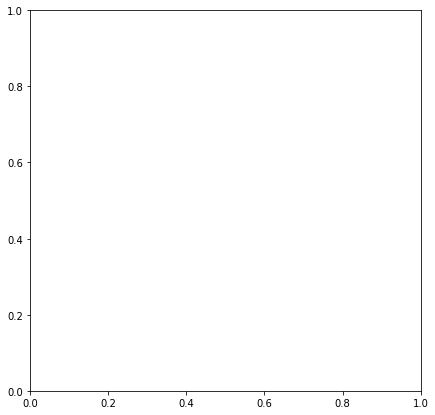

In [9]:
scatter_labels(x, y_instr, 't-sne', color_labels = color_labels)

In [ ]:
scatter_labels(x, y_instr, 'pca', color_labels = color_labels)

In [ ]:
scatter_fuzzy(x, y_pitch, 't-sne')

In [ ]:
scatter_fuzzy(x, y_pitch, 'pca')

Latent Representation with Triplets

In [13]:
z_timbre_list = []
z_pitch_list = []
pitch_label = []
instr_label = []
total_iter = 2000
for idx, data in enumerate(dataset):
    #data['anc_data'] = data['anc_data'].unsqueeze(0).to(device)
    data['data'] = data['data'].unsqueeze(0).to(device)
    
    # latent, skip = autoencoder.encode(data['anc_data']) #data['src_data']
    #latent = autoencoder.encode(data['anc_data']) # data['src_data']
    #z_timbre, z_pitch = autoencoder.encode(data['anc_data']) # data['src_data'] # Cascade AE
    #latent, _ = autoencoder.encode(data['anc_data']) # data['src_data'] # VAE
    #_, z_timbre, z_pitch = autoencoder.infer(data['data']) # data['src_data'] # GMVAE
    z_timbre, z_pitch = autoencoder.encode(data['data']) # data['src_data'] # Dual
    
    #z_timbre, z_pitch = torch.chunk(latent, chunks=2, dim=1)
    
    z_timbre_list.append(z_timbre.squeeze().cpu().detach().numpy())
    z_pitch_list.append(z_pitch.squeeze().cpu().detach().numpy())
    #pitch_label.append(torch.argmax(data['anc_pitch'], dim=0, keepdims=False).numpy())
    pitch_label.append(torch.argmax(data['pitch'], dim=0, keepdims=False).numpy())
    #instr_label.append(data['anc_instr'].numpy())
    
    instr_id = torch.argmax(data['instr'], dim=0, keepdims=False).numpy()
    #instr_family_label = df[df['instrument'] == 
    #                        dataset.instru_list[instr_id]]['instrument_family'].iloc[0]
    
    instr_label.append(instr_id)
    #instr_label.append(instr_family_label)
    
    if idx % 500 == 0:
        print('{} samples...'.format(idx))
    if idx >= total_iter-1:
        print('{} samples have been Encoded/Decoded'.format(idx))
        break
z_timbre = np.stack(z_timbre_list,axis=0)
z_pitch = np.stack(z_pitch_list,axis=0)
y_pitch = np.array(pitch_label)
y_instr = np.array(instr_label)

0 samples...
500 samples...
1000 samples...
1500 samples...
1999 samples have been Encoded/Decoded


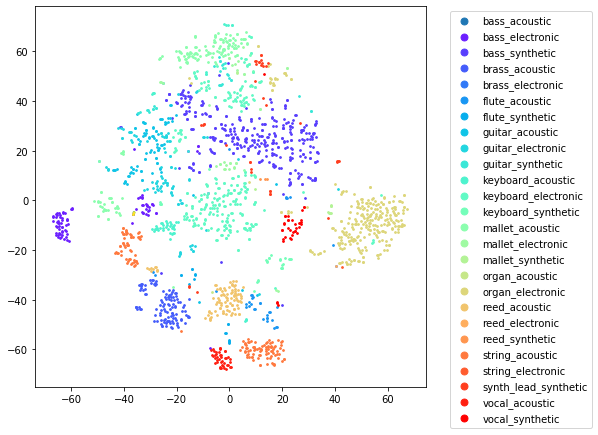

In [14]:
scatter_labels(z_timbre, y_instr, 't-sne', color_labels = color_labels)

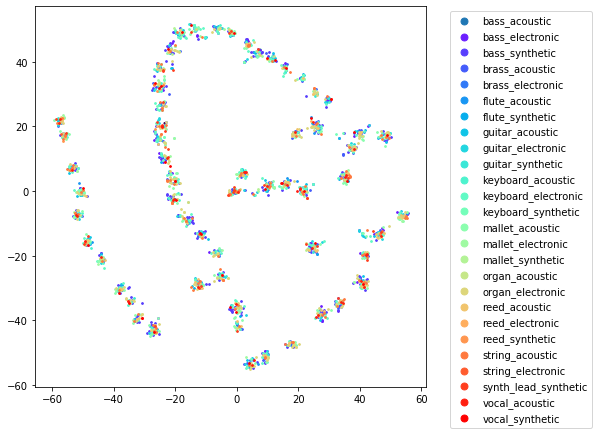

In [15]:
scatter_labels(z_pitch, y_instr, 't-sne', color_labels = color_labels)

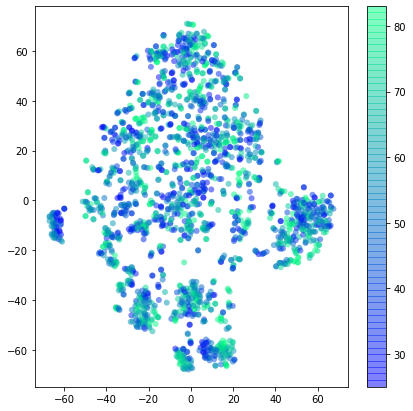

In [16]:
scatter_fuzzy(z_timbre, y_pitch, 't-sne')

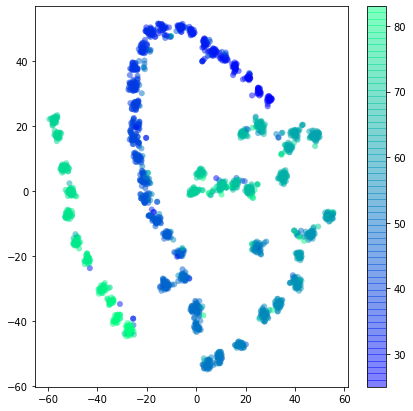

In [17]:
scatter_fuzzy(z_pitch, y_pitch, 't-sne')

## Accuracy

First, we evaluate the accuracy of pitch and/or timbre classification from latent embeddings.

In [8]:
def evaluate_acc(generic_dataset, session_name = 'Bar Desc'):
    correct_timbre = 0
    correct_pitch = 0
    prg_bar = tqdm(generic_dataset, desc= session_name)
    for data in prg_bar:
        data['data'] = data['data'].unsqueeze(0).to(device)
        #data['pitch'] = data['pitch'].unsqueeze(0).to(device)
        
        _,_,_, pred_timbre, pred_pitch = autoencoder(data['data'])
        #pred_timbre = autoencoder(data['data'], torch.argmax(data['pitch'], dim=0).to(device))[0]
        #pred_timbre = autoencoder(data['data'])[0]
        #pred_pitch = -1
        
        real_timbre = torch.argmax(data['instr'], dim=0, keepdims= False).cpu().numpy()
        pred_timbre = torch.argmax(pred_timbre, dim=1, keepdims= False).cpu().numpy()
        real_pitch = torch.argmax(data['pitch'],dim=0).cpu().numpy()
        pred_pitch = torch.argmax(pred_pitch, dim=1, keepdims= False).cpu().numpy()
        
        correct_timbre = correct_timbre + 1 if real_timbre == pred_timbre else correct_timbre
        correct_pitch = correct_pitch + 1 if real_pitch == pred_pitch else correct_pitch
        
    print('Sample size: {} | Pitch Accuracy: {} | Timbre Accuracy: {}'.format(len(generic_dataset),
                            correct_pitch/len(generic_dataset)*100, correct_timbre/len(generic_dataset)*100))
            
# Training accuracy
evaluate_acc(dataset, 'Training')

# Validation accuracy
evaluate_acc(evalset, 'Validation')

Validation:   0%|          | 6/22988 [00:00<06:52, 55.67it/s]

Sample size: 207030 | Pitch Accuracy: 99.31072791382891 | Timbre Accuracy: 99.62903926967105


Validation: 100%|██████████| 22988/22988 [04:08<00:00, 92.69it/s] 

Sample size: 22988 | Pitch Accuracy: 98.19036018792413 | Timbre Accuracy: 99.27353401774839


In [8]:
def evaluate_acc(generic_dataset, session_name = 'Bar Desc'):
    correct_timbre = 0
    correct_pitch = 0
    prg_bar = tqdm(generic_dataset, desc= session_name)
    for data in prg_bar:
        data['data'] = data['data'].unsqueeze(0).to(device)
        #data['pitch'] = data['pitch'].unsqueeze(0).to(device)
        
        #_,_,_, pred_timbre, pred_pitch = autoencoder(data['data'])
        _, timbre_emb, pitch_emb, _, _ = autoencoder(data['data'])
        pred_timbre = disc_t(pitch_emb)
        pred_pitch = disc_p(timbre_emb)
        #pred_timbre = autoencoder(data['data'], torch.argmax(data['pitch'], dim=0).to(device))[0]
        #pred_timbre = autoencoder(data['data'])[0]
        #pred_pitch = -1
        
        real_timbre = torch.argmax(data['instr'], dim=0, keepdims= False).cpu().numpy()
        pred_timbre = torch.argmax(pred_timbre, dim=1, keepdims= False).cpu().numpy()
        real_pitch = torch.argmax(data['pitch'],dim=0).cpu().numpy()
        pred_pitch = torch.argmax(pred_pitch, dim=1, keepdims= False).cpu().numpy()
        
        correct_timbre = correct_timbre + 1 if real_timbre == pred_timbre else correct_timbre
        correct_pitch = correct_pitch + 1 if real_pitch == pred_pitch else correct_pitch
        
    print('Sample size: {} | Pitch Accuracy: {} | Timbre Accuracy: {}'.format(len(generic_dataset),
                            correct_pitch/len(generic_dataset)*100, correct_timbre/len(generic_dataset)*100))
            
# Training accuracy
evaluate_acc(dataset, 'Training')

# Validation accuracy
evaluate_acc(evalset, 'Validation')

Validation:   0%|          | 12/22988 [00:00<03:17, 116.08it/s]

Sample size: 207030 | Pitch Accuracy: 2.1605564410954936 | Timbre Accuracy: 17.9278365454282


Validation: 100%|██████████| 22988/22988 [03:14<00:00, 118.46it/s]

Sample size: 22988 | Pitch Accuracy: 1.7182878023316515 | Timbre Accuracy: 17.913694101270227


Evaluating the accuracy of the top-5.

In [21]:
def evaluate_topk_acc(generic_dataset, topk=1,  session_name = 'Bar Desc'):
    correct_timbre = 0
    prg_bar = tqdm(generic_dataset, desc= session_name)
    for data in prg_bar:
        data['data'] = data['data'].unsqueeze(0).to(device)
        
        #_,_,_, pred_timbre, pred_pitch = autoencoder(data['data'])
        #pred_timbre = autoencoder(data['data'], torch.argmax(data['pitch'], dim=0).to(device))[0]
        pred_timbre = autoencoder(data['data'])[0]
        
        real_timbre = torch.argmax(data['instr'], dim=0, keepdims= False).cpu().numpy()
        pred_topk, pred_idx = torch.topk(pred_timbre, topk, dim=1)
        
        pred_idx = pred_idx[0,:].cpu().numpy()
        for idx in pred_idx:
            if idx == real_timbre:
                correct_timbre = correct_timbre + 1
                break
    print('Sample size: {} | Timbre Accuracy: {}'.format(len(generic_dataset),
                                    correct_timbre/len(generic_dataset)*100))
            
# Training accuracy
evaluate_topk_acc(dataset, topk=2, session_name='Training')

# Validation accuracy
evaluate_topk_acc(evalset, topk=2, session_name='Validation')

Validation:   1%|          | 17/2801 [00:00<00:16, 168.81it/s]

Sample size: 66067 | Timbre Accuracy: 97.1604583226119


Validation: 100%|██████████| 2801/2801 [00:15<00:00, 175.44it/s]

Sample size: 2801 | Timbre Accuracy: 94.93038200642627


Plotting Confusion Matrix

Validation:   0%|          | 0/22988 [00:00<?, ?it/s]

Sample size: 207030 | Timbre Accuracy: 91.44182002608318


Validation: 100%|██████████| 22988/22988 [01:42<00:00, 225.33it/s]


Sample size: 22988 | Timbre Accuracy: 91.06925352357752


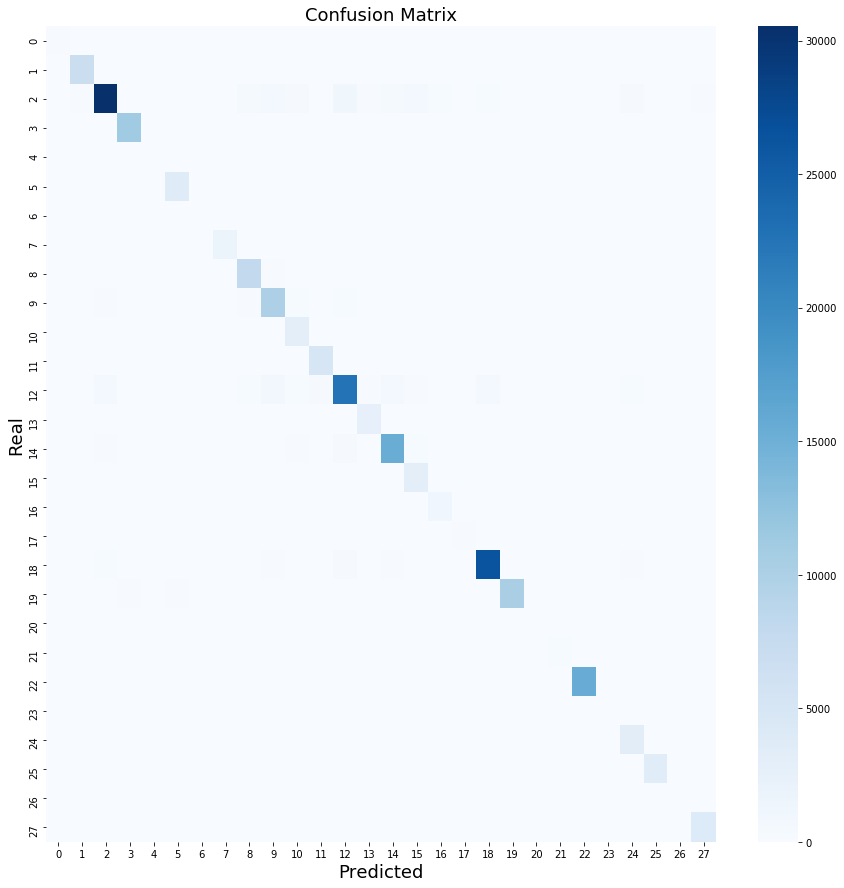

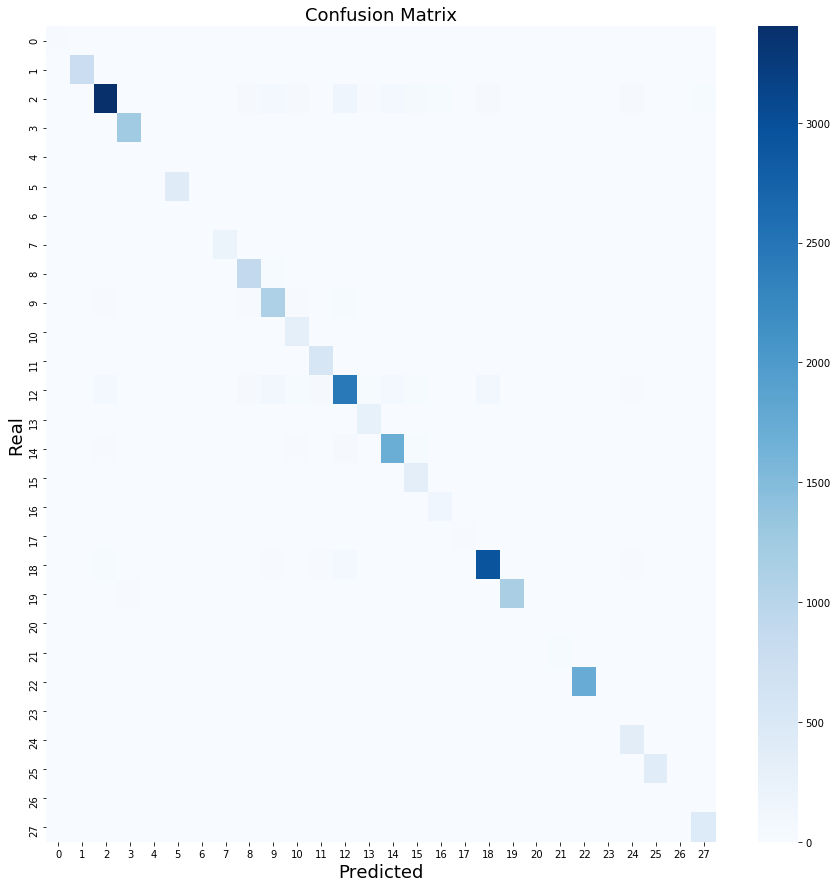

In [10]:
def evaluate_acc_cm(generic_dataset, session_name = 'Bar Desc'):
    correct_timbre = 0
    class_size = generic_dataset.timbre_class_size
    cm =np.zeros((class_size, class_size)) # Confusion Matrix
    prg_bar = tqdm(generic_dataset, desc= session_name)
    for data in prg_bar:
        data['data'] = data['data'].unsqueeze(0).to(device)
        
        #_,_,_, pred_timbre, pred_pitch = autoencoder(data['data'])
        #pred_timbre = autoencoder(data['data'], torch.argmax(data['pitch'], dim=0).to(device))[0]
        pred_timbre = autoencoder(data['data'])[0]
        
        real_timbre = torch.argmax(data['instr'], dim=0, keepdims= False).cpu().numpy()
        pred_timbre = torch.argmax(pred_timbre, dim=1, keepdims= False).cpu().numpy()
        correct_timbre = correct_timbre + 1 if real_timbre == pred_timbre else correct_timbre
        
        cm[real_timbre,pred_timbre] += 1
        
    
    print('Sample size: {} | Timbre Accuracy: {}'.format(len(generic_dataset),
                                    correct_timbre/len(generic_dataset)*100))
    plot_confusion_matrix(cm)
    return cm
            
# Training accuracy
train_cm = evaluate_acc_cm(dataset, 'Training')

# Validation accuracy
eval_cm = evaluate_acc_cm(evalset, 'Validation')

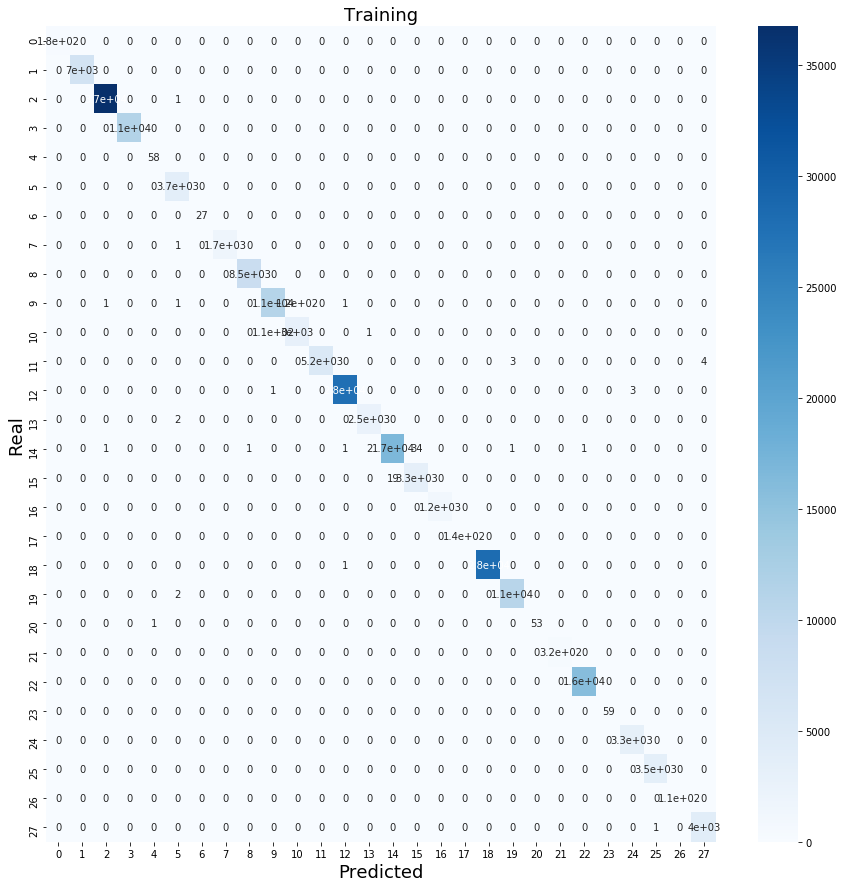

In [16]:
plot_confusion_matrix(train_cm, "Training", annot=True)

Largest error indeces: [12  2  9 14 18  8 15 19 10]


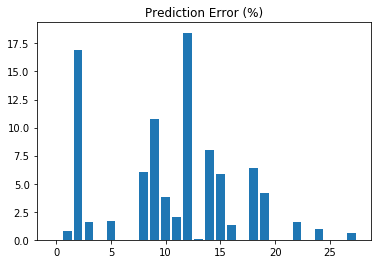

In [11]:
train_correct = np.diagonal(train_cm)
#plt.bar(range(len(train_correct)), train_correct, align='center')

real_values = np.sum(train_cm, axis=1)
#plt.bar(range(len(real_values)), real_values, align='center')

pred_err = (real_values-train_correct)/real_values*100
plt.bar(range(len(pred_err)), pred_err, align='center')
plt.title('Prediction Error (%)')

sorted_pred_idx = pred_err.argsort()[::-1] # The greatest error is the first element and so on
print("Largest error indeces: {}".format(sorted_pred_idx[:9]))

In [21]:
# Getting metadata about the top error classes.
idx = 20 # Fake index
print(pred_err[idx])
# print(real_values[idx])
#real_idx = dataset.instru_list[idx] # Dataset index
# print(df[df['family_source_id'] == real_idx].iloc[0,-1]).
print(df[df['family_source_id'] == idx].iloc[0,-1])

1.8518518518518516
reed_electronic_000-082-127


In [18]:
# Identifying the classes that generates misclassifications to the top error classes.
idx_list = sorted_pred_idx[1:9]

for idx in idx_list:
    real_count = real_values[idx]
    pred_arr = train_cm[idx, :]
    pred_max_idx = np.argmax(pred_arr)
    pred_max_count = pred_arr[pred_max_idx]
    
    real_pred_max_idx = dataset.instru_list[pred_max_idx]
    name = df[df['instrument'] == real_pred_max_idx].iloc[0,-1]
    print("Fake Index: {} | Name: {} | Misselected(%): {}".format(pred_max_idx, 
            name, pred_max_count/real_count*100))

AttributeError: 'NSynth' object has no attribute 'instru_list'

Fitting a **SVM** model as classifier, substituting the FC layers.

In [ ]:
def collect_features(generic_dataset, session_name = 'Bar Desc'):
    x = []
    y = []
    prg_bar = tqdm(generic_dataset, desc= session_name)
    for data in prg_bar:
        data['anc_data'] = data['anc_data'].unsqueeze(0).to(device)
        
        #_,_,_, pred_timbre, pred_pitch = autoencoder(data['data'])
        embedding = autoencoder(data['anc_data'])[1]
        
        x.append(embedding.squeeze(0).cpu().detach().numpy())
        y.append(torch.argmax(data['anc_instr'], dim=0).numpy())
        
    return x, y

x_train, y_train = collect_features(dataset, 'Training')
x_val, y_val = collect_features(evalset, 'Validation')

Fit a SVM model

In [ ]:
from sklearn import svm

clf = svm.SVC(kernel='poly', degree=4, decision_function_shape='ovr')
clf.fit(x_train, y_train)

In [ ]:
def compute_accuracy(model, x, y):
    i = 0
    correct=0
    for x_, y_ in zip(x, y):
        pred = model.predict(np.expand_dims(x_, axis=0))
        if pred[0] == y_:
            correct+=1
        i+=1 
    print("Accuracy: {}".format(correct/i*100))
    
compute_accuracy(clf, x_train, y_train)
compute_accuracy(clf, x_val, y_val)

## Audio Feature Extraction

In [66]:
# Taken from the paper: https://arxiv.org/pdf/1810.07217.pdf
sr = 16000
n_fft = 2048
win_len = 2048
n_mel = 256
hop = 256
window = 'hann'
fmin = 27
fmax = 11000

# Audio Sample
sample_list = ['string_acoustic_022-045-025', 'reed_acoustic_041-065-127','reed_acoustic_055-040-025', 
               'brass_acoustic_064-060-025', 'mallet_acoustic_006-055-025', 'guitar_acoustic_028-045-025', 
               'organ_electronic_050-050-025', 'keyboard_acoustic_010-048-100', 'vocal_acoustic_012-053-100']
sample_name = sample_list[3]
#sample = read_sample(sample_name)

path = os.path.join(get_datapath(sample_name), sample_name + '.wav')
sample = read_sample(sample_name, get_datapath(sample_name))
# sample, sr = librosa.load(path, sr= 16000, mono = True, duration=1)

print('Original audio')
ipd.Audio(sample, rate=16000)

Original audio


In [67]:
spec = librosa.stft(sample, n_fft=n_fft, hop_length = hop, 
           win_length=win_len, window=window)
print(spec.shape)
spec = np.log(np.abs(spec) + 1.0e-6)[:n_fft//2]
spec = expand(spec)
spec, _ = signal_utils.specgrams_to_melspecgrams(magnitude = spec, mel_downscale=n_fft//(2*n_mel))
print(spec.shape)

# Reconstructing
spec, _ = signal_utils.melspecgrams_to_specgrams(spec, mel_downscale=n_fft//(2*n_mel))
spec = np.vstack((spec,spec[-1]))
spec =  np.exp(spec) - 1.0e-6
spec = np.abs(spec)
r_audio = librosa.griffinlim(spec, n_iter= 50, 
                            hop_length=hop, win_length=win_len)
ipd.Audio(r_audio, rate=16000)

(1025, 251)
(256, 256)


Alternative

In [64]:
spec = librosa.feature.melspectrogram(y=sample, sr=16000, n_fft=n_fft, hop_length=hop, 
                                   n_mels=n_mel, fmin=fmin, fmax=fmax)
mel_filter = librosa.filters.mel(sr=16000, n_fft=n_fft, n_mels=n_mel, fmin=fmin, fmax=fmax)

spec = expand(spec)
print(spec.shape)
stft = np.dot(mel_filter.T, spec)
print(stft.shape)
r_audio_2 = librosa.griffinlim(stft, n_iter= 100, 
                            hop_length=hop, win_length=win_len)
ipd.Audio(r_audio_2, rate=16000)

(256, 256)
(1025, 256)


## Pitch Shifting

By using the librosa pitch shifting method we can shift the pitch while remaining the sample size constant.

In [ ]:
sample_list = ['string_acoustic_022-045-025', 'reed_acoustic_041-065-127','reed_acoustic_055-040-025', 
               'brass_acoustic_064-060-025', 'mallet_acoustic_006-055-025','flute_synthetic_004-045-025']
sample_name = sample_list[1]

# Reading sample
sample = read_sample(sample_name)[:16000]
print_properties(sample)

ipd.Audio(sample, rate=16000)

In [ ]:
shifted = librosa.effects.pitch_shift(sample, 16000, n_steps=-10)
print_properties(shifted)

ipd.Audio(shifted, rate=16000)

## Data Augmentation

In [ ]:
sample_list = ['string_acoustic_022-045-025', 'reed_acoustic_041-065-127','reed_acoustic_055-040-025', 
               'brass_acoustic_064-060-025', 'mallet_acoustic_006-055-025','flute_synthetic_004-045-025']
sample_name = sample_list[0]

# Reading sample
sample = read_sample(sample_name)[:16000]
print_properties(sample)

# Noise sample
sample_noisy = sample * np.random.uniform(0.98, 1.02, len(sample)) + np.random.uniform(-0.005, 0.005, len(sample))

# Time Shifting
start_ = int(np.random.uniform(-4800,4800))
testtimbreclasspitch55_model

plot_spectrogram_from_samples(sample)
plot_spectrogram_from_samples(sample_noisy)
plot_spectrogram_from_samples(sample_shifted)

In [ ]:
# Feature Extraction
spec = librosa.stft(sample, n_fft=n_fft, hop_length = hop_length, window=window)
mag = np.abs(spec)**2
print(mag.min())
print(mag.max())
angle = np.angle(spec)

#mel_spec = librosa.feature.melspectrogram(sample, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mel, fmin=fmin, fmax=fmax)
mel_spec = librosa.feature.melspectrogram(S=mag, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mel, fmin=fmin, fmax=fmax)
plt.imshow(librosa.power_to_db(mel_spec), aspect='auto', origin='lower')
log_mel_spec = np.log(mel_spec + 1e-6)
# Norm
norm_log_m = log_mel_spec*0.0674 + 0.1316
print(norm_log_m.min())
print(norm_log_m.max())

# Reconstruction
denorm_log_m = (norm_log_m - 0.1316)/0.0674
recon_mel = np.exp(denorm_log_m) - 1.0e-6
mel_filter = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mel, fmin=fmin, fmax=fmax)
recon_mag = np.dot(mel_filter.T, recon_mel)
print(recon_mag.min())
print(recon_mag.max())
#plt.imshow(librosa.power_to_db(recon_mag), aspect='auto', origin='lower')
#plt.imshow(log_mel_spec, aspect='auto', origin='lower')

# Phase
# IF = signal_utils.instantaneous_frequency(angle, time_axis=1)[:n_fft//2]
# plot_spec(IF)
# mel_IF= librosa.feature.melspectrogram(S=IF, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mel, fmin=fmin, fmax=fmax)
# plot_spec(mel_IF)
# recon_IF = np.dot(mel_filter.T, mel_IF)
# plot_spec(recon_IF)

recon_audio = librosa.griffinlim(recon_mag, n_iter= 50, hop_length=hop_length, window = window)
ipd.Audio(recon_audio, rate=22050)

In [ ]:
# Feature Extraction
spec = librosa.stft(sample, n_fft=n_fft, hop_length = hop_length, window=window)
mag = np.log(np.abs(spec)**2)[:n_fft//2]
#mag = np.abs(spec)**2
#mag = mag[:n_fft//2]
print(mag.min())
print(mag.max())
angle = np.angle(spec)

#mel_spec = librosa.feature.melspectrogram(sample, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mel, fmin=fmin, fmax=fmax)
mel_spec = signal_utils.specgrams_to_melspecgrams(magnitude=mag, mel_downscale= n_fft//512)[0]
print(mel_spec)
#plt.imshow(librosa.power_to_db(mel_spec), aspect='auto', origin='lower')
plt.imshow(mel_spec, aspect='auto', origin='lower')
#log_mel_spec = np.log(mel_spec + 1e-6)

# Norm
#norm_log_m = log_mel_spec*0.0674 + 0.1316
#print(norm_log_m.min())
#print(norm_log_m.max())

# Reconstruction
#denorm_log_m = (norm_log_m - 0.1316)/0.0674
#mel_filter = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mel, fmin=fmin, fmax=fmax)
#recon_mag = np.dot(mel_filter.T, recon_mel)
recon_mag = signal_utils.melspecgrams_to_specgrams(logmelmag2= mel_spec, mel_downscale= n_fft//512)[0]
recon_mag = np.exp(recon_mag) - 1.0e-6
print(recon_mag.min())
print(recon_mag.max())
print(recon_mag.shape)
#plt.imshow(librosa.power_to_db(recon_mag), aspect='auto', origin='lower')
#plt.imshow(log_mel_spec, aspect='auto', origin='lower')

# Phase
# IF = signal_utils.instantaneous_frequency(angle, time_axis=1)[:n_fft//2]
# plot_spec(IF)
# mel_IF= librosa.feature.melspectrogram(S=IF, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mel, fmin=fmin, fmax=fmax)
# plot_spec(mel_IF)
# recon_IF = np.dot(mel_filter.T, mel_IF)
# plot_spec(recon_IF)

recon_audio = librosa.griffinlim(recon_mag, n_iter= 100, hop_length=hop_length, window = window)
ipd.Audio(recon_audio, rate=22050)

## Skip Connection Visualization

## Rainbowgrams

In [ ]:
sample_name = 'string_acoustic_022-040-025'
wave, sr = librosa.core.load(os.path.join(datapath, sample_name + '.wav'), sr=16000)
rain = wave2rain(wave, sr=sr, n_fft=2048, stride=256, power= 1,log_mag=True, clip=0.1, mel_freq=True)
print(rain.shape)

ax = rain2graph(rain)

scaler = ax.set_yscale
kwargs = dict()
#kwargs['basey'] = 2
#kwargs['linthreshy'] = 1000.0
#kwargs['linscaley'] = 0.5
#scaler(mode, **kwargs)
plt.show()

## Time Analysis

In [ ]:
iters = 500
timer = 0
device = 'cuda:0'
autoencoder.to(device)
for idx, data in enumerate(dataset):
    data['src_data'] = data['src_data'].unsqueeze(0).to(device)
    
    start_iter = time.time()
    autoencoder(data['src_data'])
    timer += time.time() - start_iter    
    
    if idx % 100 == 0:
        print('{} samples...'.format(idx))
    if idx >= iters-1:
        break

print('Device={} | Iters={} | Total time={} | Average Time={}'.format(
        device, iters, timer, timer/iters))

In [52]:
df.head()

note  sample_rate  pitch  instrument_source instrument_family_str  \
0   16629        16000     82                  0                guitar   
1   88495        16000     50                  1                 organ   
2  146382        16000     26                  1                guitar   
3  244275        16000     79                  1                 organ   
4  282051        16000     44                  1              keyboard   

            instrument_str                         note_str  \
0      guitar_acoustic_001      guitar_acoustic_001-082-050   
1     organ_electronic_120     organ_electronic_120-050-127   
2    guitar_electronic_021    guitar_electronic_021-026-025   
3     organ_electronic_011     organ_electronic_011-079-075   
4  keyboard_electronic_089  keyboard_electronic_089-044-100   

              qualities_str instrument_source_str  velocity  \
0              [percussive]              acoustic        50   
1                        []            electronic       127   
2  [fast_decay, percussive]            electronic        25   
3                  [bright]            electronic        75   
4                        []            electronic       100   

   instrument_family  instrument                       qualities  stage  \
0                  3          39  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]  train   
1                  6         979  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  train   
2                  3         346  [0, 0, 0, 1, 0, 0, 0, 1, 0, 0]  train   
3                  6         188  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]  train   
4                  4         877  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  train   

   family_source_id                             file  
0                 8      guitar_acoustic_001-082-050  
1                18     organ_electronic_120-050-127  
2                 9    guitar_electronic_021-026-025  
3                18     organ_electronic_011-079-075  
4                12  keyboard_electronic_089-044-100

In [134]:
df[(df['instrument_family_str'] == 'keyboard') & (df['instrument_source_str'] == 'synthetic')]['instrument_str'].unique()

array(['keyboard_synthetic_012', 'keyboard_synthetic_006',
       'keyboard_synthetic_004', 'keyboard_synthetic_010',
       'keyboard_synthetic_009', 'keyboard_synthetic_008',
       'keyboard_synthetic_011', 'keyboard_synthetic_001',
       'keyboard_synthetic_002', 'keyboard_synthetic_003',
       'keyboard_synthetic_007', 'keyboard_synthetic_005',
       'keyboard_synthetic_000'], dtype=object)

## Audio Reconstruction

In [129]:
df[(df['instrument_family_str'] == 'vocal') & (df['instrument_source_str'] == 'acoustic') & (df['pitch'] == 53)].head()

note  sample_rate  pitch  instrument_source instrument_family_str  \
2434   34149        16000     53                  0                 vocal   
3991   47596        16000     53                  0                 vocal   
8603    4293        16000     53                  0                 vocal   
11677  35302        16000     53                  0                 vocal   
12089  10989        16000     53                  0                 vocal   

           instrument_str                    note_str  \
2434   vocal_acoustic_004  vocal_acoustic_004-053-100   
3991   vocal_acoustic_004  vocal_acoustic_004-053-075   
8603   vocal_acoustic_012  vocal_acoustic_012-053-100   
11677  vocal_acoustic_027  vocal_acoustic_027-053-100   
12089  vocal_acoustic_012  vocal_acoustic_012-053-127   

                      qualities_str instrument_source_str  velocity  \
2434                 [dark, reverb]              acoustic       100   
3991                 [dark, reverb]              acoustic        75   
8603         [long_release, reverb]              acoustic       100   
11677  [dark, long_release, reverb]              acoustic       100   
12089        [long_release, reverb]              acoustic       127   

       instrument_family  instrument                       qualities  stage  \
2434                  10         122  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0]  train   
3991                  10         122  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0]  train   
8603                  10         281  [0, 0, 0, 0, 1, 0, 0, 0, 1, 0]  train   
11677                 10         467  [0, 1, 0, 0, 1, 0, 0, 0, 1, 0]  train   
12089                 10         281  [0, 0, 0, 0, 1, 0, 0, 0, 1, 0]  train   

       family_source_id                        file  
2434                 25  vocal_acoustic_004-053-100  
3991                 25  vocal_acoustic_004-053-075  
8603                 25  vocal_acoustic_012-053-100  
11677                25  vocal_acoustic_027-053-100  
12089                25  vocal_acoustic_012-053-127

In [126]:
df.groupby(['instrument_family_str']).size()

instrument_family_str
bass          43955
brass         11533
flute          5459
guitar        22863
keyboard      35485
mallet        21313
organ         28368
reed          11143
string        15931
synth_lead     3301
vocal          7679
dtype: int64

In [21]:
sample_list = ['string_acoustic_022-045-025', 'reed_acoustic_041-065-127','reed_acoustic_055-040-025', 
               'brass_acoustic_064-060-025', 'mallet_acoustic_006-055-025', 'flute_synthetic_004-045-025',
               'guitar_acoustic_028-045-025', 'organ_electronic_050-050-025', 'keyboard_acoustic_010-048-100', 
               'vocal_acoustic_012-053-100']

sample_name = sample_list[2]
sample_datapath = get_datapath(sample_name, 'data/nsynth')

sample = read_sample(sample_name, sample_datapath)
#sample = read_samples_librosa(sample_name)
print("sample size: {}".format(sample.shape))

sample size: (64000,)


Feature shape: (1, 1024, 64)


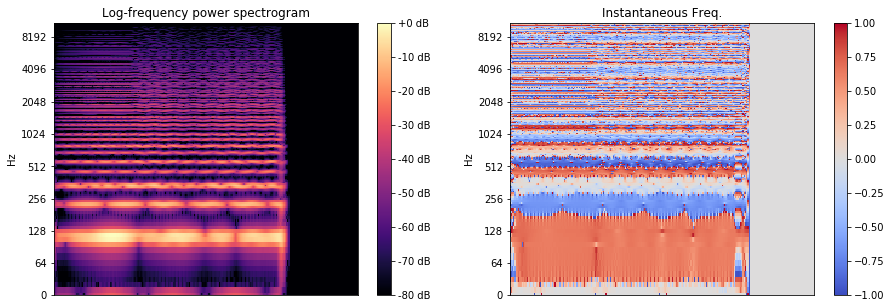

In [22]:
data = arrange_data(sample)
data_arr = data[0,:,:,:].cpu().detach().numpy()

print("Feature shape: {}".format(data_arr.shape))
plot_spectrogram_from_samples(sample)
# rainbowgram(sample)
ipd.Audio(sample, rate=16000)

(1024, 64)


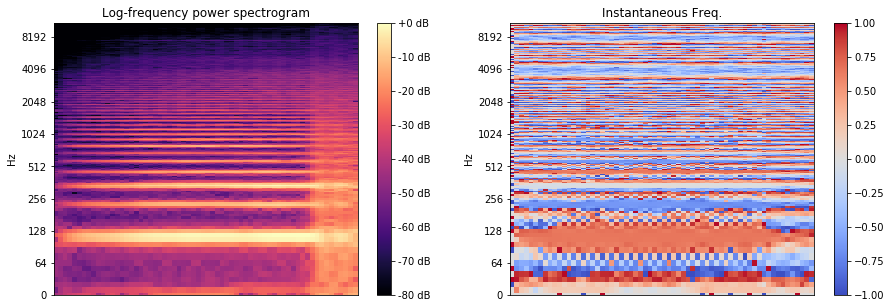

In [23]:
recon_spec = generate(data, recon_only=True)#data[0,0,:,:].cpu().detach().numpy()
print(recon_spec.shape)
recon_sample = reconstruct(recon_spec, 100)
plot_spectrogram_from_samples(recon_sample)
# rainbowgram(sample)
ipd.Audio(recon_sample, rate=16000)

special cases

In [15]:
recon_spec = autoencoder.infer(data)[0]
recon_spec = recon_spec.squeeze().cpu().detach().numpy()
recon_spec = denorm(spec = recon_spec)[0]
recon_spec = signal_utils.melspecgrams_to_specgrams(recon_spec, mel_downscale=2048//512)[0]
recon_spec = np.exp(recon_spec) - 1e-6
recon_spec = np.abs(recon_spec)
#recon_spec = dataset.mel_to_spec(recon_spec)
#plt.imshow(librosa.power_to_db(recon_spec), aspect='auto', origin='lower')
print_properties(recon_spec)

recon_sample = librosa.griffinlim(recon_spec, n_iter= 100, hop_length= dataset.hop, window = dataset.window)
plot_spectrogram_from_samples(recon_sample)
ipd.Audio(recon_sample, rate=dataset.rate)

AttributeError: 'DualGanSynthAEWithPTClass' object has no attribute 'infer'

## Phase Reconstruction

We use a network to map from Log-Magnitude spectrogram to Phase information, the phase can be in the form of Raw phase, IF or Group-Delay.

In [ ]:
converter = networks.instantiate_mag2phase(opt).to(device)

snap_path = os.path.join(checkpoints_path, 'snap')
converter.load_state_dict(torch.load(os.path.join(snap_path, 'latest_mag2phase.pth'), map_location=device))

In [ ]:
sample_list = ['string_acoustic_022-040-025', 'reed_acoustic_041-065-127']
sample_name = sample_list[1]
sample = read_sample(sample_name)
ipd.Audio(sample, rate=16000)

Frame to Frame Mapping

In [ ]:
data = arrange_data(sample)
mag = data[0,0,:,:]
real_phase = data[0,1,:,:].cpu().detach().numpy()
mag = torch.transpose(mag,0,1)
phase = converter(mag).squeeze()
phase = torch.transpose(phase,0,1).cpu().detach().numpy()

# Visualizing the converted IF feature
plt.figure()
librosa.display.specshow(phase, y_axis='log')
plt.colorbar()
plt.title('Mapped Phase')

# Visualizing the real IF feature
plt.figure()
librosa.display.specshow(real_phase, y_axis='log')
plt.colorbar()
plt.title('Ground Truth')

In [ ]:
magnitude = torch.transpose(mag,0,1).cpu().detach().numpy()
magnitude = dataset.data_norm.denormalize(magnitude)
magnitude = np.exp(magnitude) - 1.0e-6
magnitude = np.vstack((magnitude, magnitude[-1,:]))

if opt['data']['phase_format'] == 'if':
    phase = reconstruct_phase(phase)
phase = np.vstack((phase, phase[-1,:]))

# Visualizing the phase unwrapped 
plt.figure()
librosa.display.specshow(phase, y_axis='log')
plt.colorbar()

# Visualizing the phase wrapped 
plt.figure()
librosa.display.specshow(wrap(phase), y_axis='log')
plt.colorbar()
plt.title('Mapped Phase')

# Reconstructing Audio
stft = polar2rect(magnitude, phase)
audio = librosa.istft(stft, hop_length = 256, win_length = 512, window = 'hann')

ipd.Audio(audio, rate=16000)

Multi-Frame to Multi-Frame Mapping

In [ ]:
data = arrange_data(sample)
real_phase = data[0,1,:,:].cpu().detach().numpy()

phase = converter(data[:,0:1,:,:])[0].squeeze()
phase = phase.cpu().detach().numpy()

# Visualizing the converted IF feature
plt.figure()
librosa.display.specshow(phase, y_axis='log')
plt.colorbar()
plt.title('Mapped Phase')

# Visualizing the real IF feature
plt.figure()
librosa.display.specshow(real_phase, y_axis='log')
plt.colorbar()
plt.title('Ground Truth')

Audio Conversion and Visualization

In [ ]:
magnitude = data[0,0,:,:].cpu().detach().numpy()
magnitude = dataset.data_norm.denormalize(magnitude)
magnitude = np.exp(magnitude) - 1.0e-6
magnitude = np.vstack((magnitude, magnitude[-1,:]))

if opt['data']['phase_format'] == 'if':
    phase = reconstruct_phase(phase)
phase = np.vstack((phase, phase[-1,:]))

# Visualizing the phase unwrapped 
plt.figure()
librosa.display.specshow(phase, y_axis='linear')
plt.colorbar()

# Visualizing the phase wrapped 
plt.figure()
librosa.display.specshow(wrap(phase), y_axis='linear')
plt.colorbar()
plt.title('Mapped Phase')

# Reconstructing Audio
stft = polar2rect(magnitude, phase)
audio = librosa.istft(stft, hop_length = 256, win_length = 512, window = 'hann')

ipd.Audio(audio, rate=16000)

## Phase Post Reconstruction

In this section we research the posibility of adding a post processing method to the phase reconstruction step to provide with more realism.

In [ ]:
opt['model']['in_ch'] = 1 
postprocessor = networks.instantiate_autoencoder(opt).to(device)

snap_path = os.path.join(checkpoints_path, 'snap')
postprocessor.load_state_dict(torch.load(os.path.join(snap_path, 'latest_postprocessor.pth'), map_location=device))
postprocessor.device = 'cuda:0'

In [ ]:
sample_list = ['string_acoustic_022-040-025', 'reed_acoustic_041-065-127']
sample_name = sample_list[1]
sample = read_sample(sample_name)
ipd.Audio(sample, rate=16000)

In [ ]:
data = arrange_data(sample)
mag = data[0,0,:,:]
real_phase = data[0,1,:,:].cpu().detach().numpy()
mag = torch.transpose(mag,0,1)

# Map log-magnitude to IF
m2p_IF = converter(mag).squeeze()
m2p_IF = torch.transpose(m2p_IF.unsqueeze(0).unsqueeze(0),2, 3).detach()
m2p_IF_arr = m2p_IF[0,0,:,:].cpu().detach().numpy()

# Post Process IF
fake_IF = postprocessor(m2p_IF)[0]
fake_IF_arr = fake_IF[0,0,:,:].cpu().detach().numpy()

# Visualizing IF
plt.figure()
librosa.display.specshow(real_phase, y_axis='log')
plt.colorbar()
plt.title('Real IF')

plt.figure()
librosa.display.specshow(m2p_IF_arr, y_axis='log')
plt.colorbar()
plt.title('Mapped m2p IF')autoncoder

plt.figure()
librosa.display.specshow(fake_IF_arr, y_axis='log')
plt.colorbar()
plt.title('Post Processed IF')

plt.figure()
librosa.display.specshow(wrap(reconstruct_phase(fake_IF_arr)), y_axis='log')
plt.colorbar()
plt.title('Post Processed Phase')

# Vocoders

In [ ]:
sample_list = ['string_acoustic_022-040-025', 'reed_acoustic_041-065-127']
sample_name = sample_list[0]

In [ ]:
from data.nsynth_loader_vocoder import NSynthVocoder
dataset = NSynthVocoder(opt)

## Parallel WaveNet

## WaveRNN

## WaveGlow

In [ ]:
from lib.glow import WaveGlow

vocoder = WaveGlow(**opt['model']['waveglow_config'])

snap_path = os.path.join(checkpoints_path, 'snap')
vocoder.load_state_dict(torch.load(os.path.join(snap_path, 'latest_vocoder.pth'), map_location=device))
vocoder = vocoder.to(device)

Loading a pretrained Model

In [ ]:
datapath = os.path.join(dataset.root, 'audio')
path = os.path.join(datapath, sample_name + '.wav')

samples, sr = librosa.load(path, sr=22050, mono=True)
samples = samples.astype(np.float)
samples = torch.from_numpy(samples).float()[16000:16000*2]
mel = dataset.get_mel(samples)
#mel, real_audio = dataset.arrange_data(path)
mel = mel.unsqueeze(0).to(device)

# Generating audio
gen_audio = vocoder.infer(mel, 0.6)

# Playing Audio
ipd.Audio(gen_audio.detach().cpu().numpy()[0,:], rate=22050)

In [ ]:
ipd.Audio(samples.detach().cpu().numpy(), rate=22050)

In [ ]:
from waveglow_vocoder import WaveGlowVocoder
vocoder = WaveGlowVocoder()

In [ ]:
datapath = os.path.join(dataset.root, 'audio')
path = os.path.join(datapath, sample_name + '.wav')

samples, sr = librosa.load(path, sr=22050, mono=True)
samples = samples.astype(np.float)
samples = torch.from_numpy(samples).float()[:16000]
mel = dataset.get_mel(samples)
#mel, real_audio = dataset.arrange_data(path)
mel = mel.unsqueeze(0).to(device)

# Generating audio
gen_audio = vocoder.mel2wav(mel)

# Playing Audio
ipd.Audio(gen_audio.detach().cpu().numpy(), rate=22050)

In [ ]:
plot_spectrogram_from_samples(gen_audio.detach().cpu().numpy()[0,:])
ipd.Audio(gen_audio.detach().cpu().numpy(), rate=22050)

In [ ]:
plot_spectrogram_from_samples(samples.detach().cpu().numpy())
ipd.Audio(samples.detach().cpu().numpy(), rate=22050)

## Pitch Control

First we select and load a sample from the dataset.

Finding a list of pitch encodings gathered from multiple instruments. The idea is to get rid of all information of timbre in the pitch encoding.

In [10]:
available_pitch = list(df['pitch'].unique())
available_pitch.sort()
print(available_pitch)

[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]


In [14]:
pitch_embed_list = []

for pitch in available_pitch:
    sample_row = df[df['pitch'] == pitch].sample(1)
    
    sample_datapath = get_datapath(sample_row.iloc[0]['file'],'data/nsynth')
    _, sample = scipy.io.wavfile.read(os.path.join(sample_datapath, sample_row.iloc[0]['file'] + '.wav'))
    sample = sample/np.iinfo(np.int16).max
    
#     data = arrange_data(sample)
    data = arrange_data(sample)
    
    #latent = autoencoder.encode(data) # skip connection
    #pitch_embed = torch.chunk(latent, chunks=2, dim=1)[1]
    
    pitch_embed = autoencoder.encode(data)[1]
    
    pitch_embed_list.append(pitch_embed.cpu().detach().numpy())
    
print('Pitch Embeddings: {}'.format(len(pitch_embed_list)))
print('Done!')

Pitch Embeddings: 59
Done!


In [15]:
sample_list = ['string_acoustic_022-045-025', 'reed_acoustic_041-065-127','reed_acoustic_055-040-025', 
               'brass_acoustic_064-060-025', 'mallet_acoustic_006-055-025', 'flute_synthetic_004-045-025',
               'guitar_acoustic_028-045-025', 'organ_electronic_050-050-025', 'keyboard_acoustic_010-048-100', 
               'vocal_acoustic_012-053-100']

In [16]:
sample_name = sample_list[5]

sample_path = get_datapath(sample_name,'data/nsynth')
sample = read_sample(sample_name, sample_path)
data = arrange_data(sample)
ipd.Audio(sample, rate=16000)

Scale Generation without Skip connections using pitch embeddings with a unique timbre

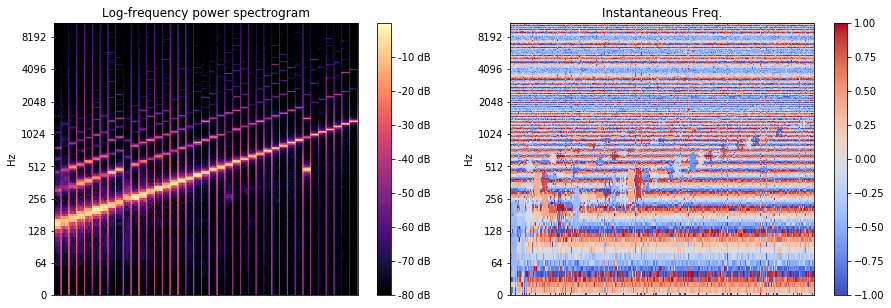

In [17]:
list_audio = []

#latent, skip = autoencoder.encode(data) # Skip connections
#latent = autoencoder.encode(data)
#timbre = torch.chunk(latent, chunks=2, dim=1)[0]

timbre = autoencoder.encode(data)[0]

for pitch_embed in pitch_embed_list[20::1]:
    # Format Embedding
    pitch_embed = torch.from_numpy(pitch_embed).float().to(device)
    # Concat
    latent = torch.cat([timbre, pitch_embed], dim = 1)
    
    #aud_recon = autoencoder.decode(latent, skip) # Skip connections
    aud_recon = autoencoder.decode(latent)
    aud_recon = aud_recon.squeeze().cpu().detach().numpy()
    aud = reconstruct(aud_recon)
    aud = aud[4000:12000]
    list_audio.append(aud)
    
list_audio = np.hstack(list_audio)
plot_spectrogram_from_samples(list_audio)
ipd.Audio(list_audio, rate=16000)

In [ ]:
export_audio(list_audio, os.path.join(output_dir, '512_trip_ch_pitch_{}.wav'.format(sample_name)))

## Pitch Interpolation

Scale Generation without Skip connections and pitch interpolation

In [7]:
list_audio = []

start_latent = autoencoder.encode(feat_start)
start_timbre, start_pitch = torch.chunk(start_latent, chunks=2, dim=1)
end_latent = autoencoder.encode(feat_end)
end_timbre, end_pitch = torch.chunk(end_latent, chunks=2, dim=1)

iters = 20

for i in range(iters+1):
    alpha = i*(1/iters)
    
    # Interpolation
    pitch_interp = start_pitch*(1-alpha) + end_pitch *alpha
    # Timbre Concat
    latent_interp = torch.cat([start_timbre, pitch_interp], dim = 1)
    
    aud_recon = autoencoder.decode(latent_interp)
    aud_recon = aud_recon.squeeze().cpu().detach().numpy()
    aud = reconstruct(aud_recon)
    aud = aud[0:8000]
    list_audio.append(aud)
    
list_audio = np.hstack(list_audio)
plot_spectrogram_from_samples(list_audio)
ipd.Audio(list_audio, rate=dataset.rate)

NameError: name 'feat_start' is not defined

## Timbre Interpolation

Defining a list of file names with different timbres but same pitch and velocity.

In [33]:
sample_list = ['string_acoustic_022-045-025', 'reed_acoustic_055-045-025', 'brass_acoustic_064-045-025',
               'mallet_acoustic_006-045-025','flute_synthetic_004-045-025']

Defining a list of file names with different timbres and pitch but same velocity.

In [34]:
sample_list = ['string_acoustic_042-050-025', 'reed_acoustic_055-040-025', 'brass_acoustic_064-060-025',
               'mallet_acoustic_006-055-025','flute_synthetic_004-045-025']

In [18]:
sample_list = ['string_acoustic_042-050-025', 'reed_acoustic_055-040-025', 'brass_acoustic_064-060-025',
               'mallet_acoustic_006-055-025','flute_synthetic_004-045-025', 'guitar_acoustic_028-045-025',
               'organ_electronic_050-050-025', 'keyboard_acoustic_010-048-100', 'vocal_acoustic_012-053-100']

In [10]:
sample_str = read_sample(sample_list[0], get_datapath(sample_list[0]))
ipd.Audio(sample_str, rate=dataset.rate)

FileNotFoundError: [Errno 2] No such file or directory: './data/nsynth-train/audio/string_acoustic_042-050-025.wav'

In [ ]:
sample_reed = read_sample(sample_list[1], get_datapath(sample_list[1]))
ipd.Audio(sample_reed, rate=dataset.rate)

In [11]:
sample_brass = read_sample(sample_list[2], get_datapath(sample_list[2]))
ipd.Audio(sample_brass, rate=dataset.rate)

FileNotFoundError: [Errno 2] No such file or directory: './data/nsynth-train/audio/brass_acoustic_064-060-025.wav'

In [12]:
sample_mallet = read_sample(sample_list[3], get_datapath(sample_list[3]))
ipd.Audio(sample_mallet, rate=dataset.rate)

FileNotFoundError: [Errno 2] No such file or directory: './data/nsynth-train/audio/mallet_acoustic_006-055-025.wav'

In [13]:
sample_flute = read_sample(sample_list[4], get_datapath(sample_list[4]))
ipd.Audio(sample_flute, rate=dataset.rate)

FileNotFoundError: [Errno 2] No such file or directory: './data/nsynth-train/audio/flute_synthetic_004-045-025.wav'

In [14]:
sample_guitar = read_sample(sample_list[5], get_datapath(sample_list[5]))
ipd.Audio(sample_guitar, rate=dataset.rate)

FileNotFoundError: [Errno 2] No such file or directory: './data/nsynth-train/audio/guitar_acoustic_028-045-025.wav'

In [15]:
sample_organ = read_sample(sample_list[6], get_datapath(sample_list[6]))
ipd.Audio(sample_organ, rate=dataset.rate)

FileNotFoundError: [Errno 2] No such file or directory: './data/nsynth-train/audio/organ_electronic_050-050-025.wav'

In [43]:
sample_keyboard = read_sample(sample_list[7], get_datapath(sample_list[7]))
ipd.Audio(sample_keyboard, rate=dataset.rate)

In [44]:
sample_vocal = read_sample(sample_list[8], get_datapath(sample_list[8]))
ipd.Audio(sample_vocal, rate=dataset.rate)

In [86]:
sample_1 = sample_keyboard
sample_2 = sample_vocal

Progressive Timbre Interpolation

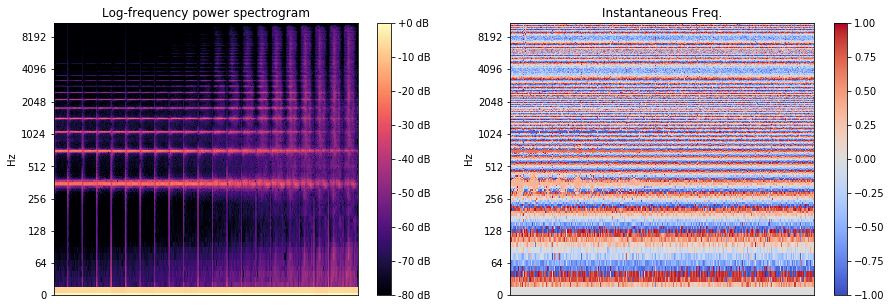

In [47]:
list_audio = []

data_1 = arrange_data(sample_1)
data_2 = arrange_data(sample_2)

timbre_1, pitch_1 = autoencoder.encode(data_1)
timbre_2, pitch_2 = autoencoder.encode(data_2)

iters = 20
last_value = 0
for i in range(iters+1):
    alpha = i*(1/iters) # 0 >> 1
    
    # Interpolation
    timbre_interp = timbre_1*(1-alpha) + timbre_2 * alpha

    # Pitch Concat
    latent_interp = torch.cat([timbre_interp, pitch_1], dim = 1) # choosing pitch_1 or pitch_2 still has impact
    
    #aud_recon = autoencoder.decode(latent_interp, skip_1) # Skip connections
    aud_recon = autoencoder.decode(latent_interp)
    aud_recon = aud_recon.squeeze().cpu().detach().numpy()
    aud = reconstruct(aud_recon)
    aud = aud[0:12000]
    # Normalizing to [-1,1]to equalize the audio volume
    aud = linear_norm(aud,-1,1)
    list_audio.append(aud)
    
list_audio = np.hstack(list_audio)
plot_spectrogram_from_samples(list_audio)
ipd.Audio(list_audio, rate=16000)

Progressive Latent Code Interpolation

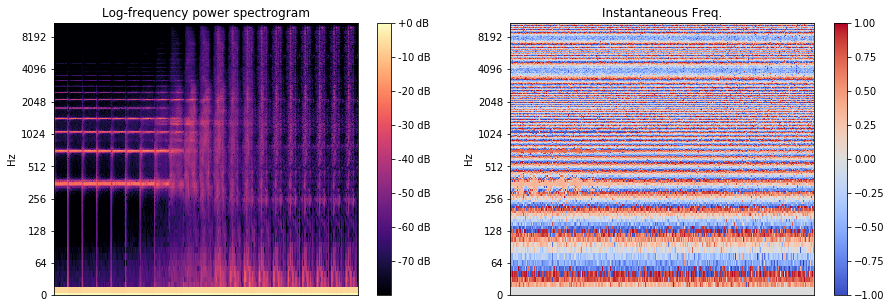

In [48]:
list_audio = []

data_1 = arrange_data(sample_1)
data_2 = arrange_data(sample_2)

timbre_1, pitch_1 = autoencoder.encode(data_1)
timbre_2, pitch_2 = autoencoder.encode(data_2)

iters = 20
last_value = 0
for i in range(iters+1):
    alpha = i*(1/iters) # 0 >> 1
    # Interpolation
    timbre_interp = timbre_1*(1-alpha) + timbre_2 * alpha
    
    # Pitch interpolation 
    pitch_interp = pitch_1*(1-alpha) + pitch_2 * alpha

    # Pitch Concat
    latent_interp = torch.cat([timbre_interp, pitch_interp], dim = 1) # choosing pitch_1 or pitch_2 still has impact
    
    aud_recon = autoencoder.decode(latent_interp)
    aud_recon = aud_recon.squeeze().cpu().detach().numpy()
    aud = reconstruct(aud_recon)
    aud = aud[0:12000]
    # Normalizing to [-1,1]to equalize the audio volume
    aud = linear_norm(aud,-1,1)
    list_audio.append(aud)
    
list_audio = np.hstack(list_audio)
plot_spectrogram_from_samples(list_audio)
ipd.Audio(list_audio, rate=16000)

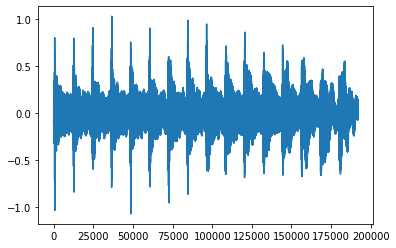

In [85]:
fig = plt.figure()
plt.plot(list_audio[::1])

In [ ]:
export_audio(list_audio, os.path.join(output_dir, '512_skiptrip_timbinterp.wav'.format(sample_name)))

## Timbre Interpolation with Natural Sound

In [7]:
# Musical samples
nsynth_list = ['string_acoustic_042-050-025', 'reed_acoustic_055-040-025', 'brass_acoustic_064-060-025',
               'mallet_acoustic_006-055-025','flute_synthetic_004-045-025']

Shape: (64000,) | Mean: -1.3990829187908172e-06 | Max: 0.9465926084170049 | Min: -0.8661152989288003
(1024, 64)


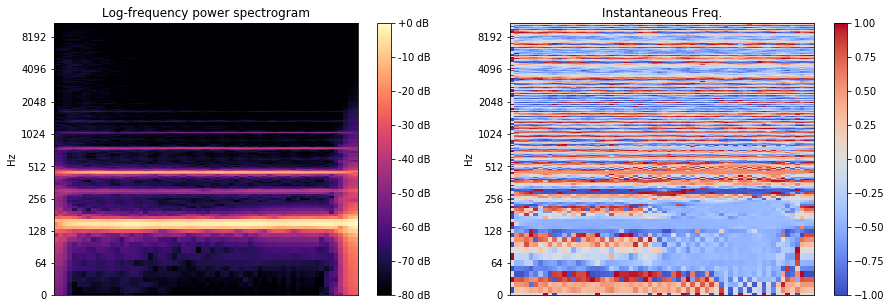

In [26]:
path_1 = './data/nsynth/nsynth-train/audio/flute_synthetic_004-045-025.wav'
_ , sample_1 = scipy.io.wavfile.read(path_1)
sample_1 =  sample_1/ np.iinfo(np.int16).max
print_properties(sample_1)
ipd.Audio(sample_1, rate=dataset.rate)

data_1 = arrange_data(sample_1)
# Reconstruction
recon_spec = generate(data_1, recon_only=True)
print(recon_spec.shape)
recon_sample = reconstruct(recon_spec, 100)
plot_spectrogram_from_samples(recon_sample)
# rainbowgram(sample)
ipd.Audio(recon_sample, rate=16000)

Shape: (64000,) | Mean: -2.3389576403088405e-06 | Max: 0.934446241645558 | Min: -0.4398632770775475
(1024, 64)


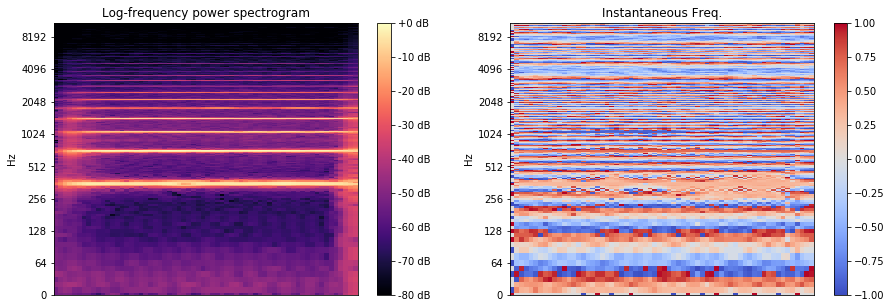

In [29]:
path_2 = './data/nsynth/nsynth-train/audio/brass_acoustic_064-060-025.wav'
_, sample_1 = scipy.io.wavfile.read(path_2)
sample_1 =  sample_1/ np.iinfo(np.int16).max # normalize [-1,1]
ipd.Audio(sample_1, rate=dataset.rate)
print_properties(sample_1)

data_1 = arrange_data(sample_1)
# Reconstruction
recon_spec = generate(data_1, recon_only=True)
print(recon_spec.shape)
recon_sample = reconstruct(recon_spec, 100)
plot_spectrogram_from_samples(recon_sample)
# rainbowgram(sample)
ipd.Audio(recon_sample, rate=16000)

fname            402651
labels    Cash_register
start                 0
end                   1
stage             train
Name: 16, dtype: object
Shape: (16000,) | Mean: -4.919546699966304e-05 | Max: 0.330589234828949 | Min: -0.3750911355018616
(1024, 64)


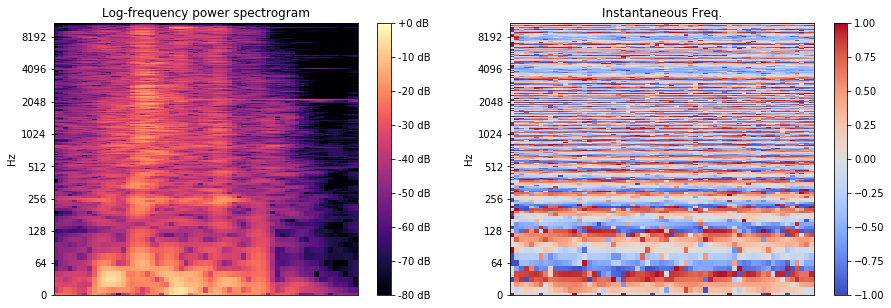

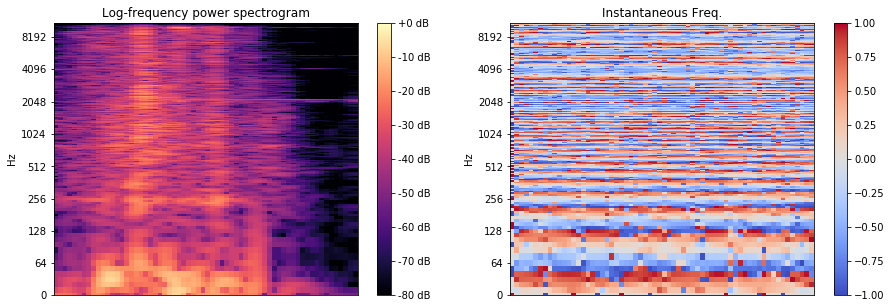

In [46]:
index =16#blender:11#1#0#10#15#16
row = dataset.fsd_df.iloc[index]
natural_sound_path = os.path.join(dataset.root, dataset.fsd_folder, 'train',
                                str(row['fname']) +'.wav')
print(row)
start = int(row['start']*dataset.rate)
end = int(row['end']*dataset.rate) if row['end'] !=-1 else -1

natural_data, sr = librosa.load(natural_sound_path, sr= dataset.rate, mono = True)
sample_2 = natural_data[start:end]
print_properties(sample_2)
plot_spectrogram_from_samples(sample_2)
ipd.Audio(sample_2, rate=dataset.rate)

data_2 = arrange_data(sample_2)
# Reconstruction
recon_spec = generate(data_2, recon_only=True)#data[0,0,:,:].cpu().detach().numpy()
print(recon_spec.shape)
recon_sample = reconstruct(recon_spec, 100)
plot_spectrogram_from_samples(recon_sample)
# rainbowgram(sample)
ipd.Audio(recon_sample, rate=16000)

# References

Visualization
- https://www.datacamp.com/community/tutorials/introduction-t-sne
- https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
- https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
